In [1296]:
# Import necessary libraries
try:
    import os
    import glob
    import joblib
    import pandas as pd
    import numpy as np

    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    from itertools import groupby

    from sklearn.pipeline import Pipeline
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
    from sklearn.compose import ColumnTransformer
    from sklearn.utils import class_weight
    from sklearn.linear_model import LogisticRegression
    from sklearn.cluster import KMeans
    from kneed import KneeLocator
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import (
        classification_report,
        confusion_matrix,
        accuracy_score,
        silhouette_score
    )
    from imblearn.over_sampling import SMOTE

    # TensorFlow and Keras for the Neural Network
    import tensorflow as tf
    from tensorflow.keras import layers, models, regularizers                 # type: ignore
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau   # type: ignore
    from tensorflow.keras.optimizers import Adam                              # type: ignore

    # Set random seeds for reproducibility
    random_state = 42
    np.random.seed(random_state)
    tf.random.set_seed(random_state)

except Exception as e:
    print(f"Error importing libraries: {e}")

In [1297]:
# Utility function to load dataset
def load_dataset(data_path='../Datasets/*.csv'):
    file_list = glob.glob(data_path)
    if len(file_list) == 1:
        df = pd.read_csv(file_list[0])
        print(f"Loaded dataset: {file_list[0]}")
    else:
        raise FileNotFoundError("No CSV file found or multiple CSV files found in the Datasets directory.")
    return df

In [1298]:
# Set the model saving path
destination = '../Models/'
os.makedirs(destination, exist_ok=True)
print(f"Model will be saved to: {destination}")

Model will be saved to: ../Models/


In [1299]:
# Load the dataset
df = load_dataset()

Loaded dataset: ../Datasets/Dataset.csv


In [ ]:
# Utility function for creating Lifetime labels
def create_labels(df, threshold_value=1500):
    # TODO: Add silhouette score
    df['Lifetime'] = np.where(df['Lifespan'] < threshold_value, 'Unacceptable', None)
    acceptable_df = df[df['Lifespan'] >= threshold_value].copy()

    # K-Means Clustering to create labels beyond 'Unacceptable'
    if len(acceptable_df) > 1:
        X_acceptable = acceptable_df[['Lifespan']]
        max_k = min(10, len(acceptable_df))
        k_values = range(1, max_k)

        # Finding the optimal number of clusters
        inertia = [KMeans(n_clusters=k, random_state=random_state).fit(X_acceptable).inertia_ for k in k_values]
        kneedle = KneeLocator(k_values, inertia, curve='convex', direction='decreasing')
        elbow_k = kneedle.elbow if kneedle.elbow is not None else 3

        kmeans = KMeans(n_clusters=elbow_k, random_state=random_state)
        acceptable_df['cluster'] = kmeans.fit_predict(X_acceptable)
        
        # Create labels based on clustering
        cluster_means = acceptable_df.groupby('cluster')['Lifespan'].mean()
        cluster_order = cluster_means.sort_values().index.tolist()
        desired_labels = ['Fair', 'Good', 'Excellent']
        
        # Assign appropriate labels
        labels = {cluster_order[i]: desired_labels[i] if i < len(desired_labels) else f'Cluster-{i}' for i in range(elbow_k)}
        acceptable_df['Lifetime'] = acceptable_df['cluster'].map(labels)

        # Update main dataframe
        df.loc[acceptable_df.index, 'Lifetime'] = acceptable_df['Lifetime']
        df.drop(columns=['cluster'], errors='ignore', inplace=True)

        # Cell 6: Plot the Elbow Method
        plt.figure(figsize=(10, 6))
        # Plot line segments with different colors
        plt.plot(k_values[:elbow_k], inertia[:elbow_k], 'bo-', label="Decreasing Phase")
        plt.plot(k_values[elbow_k - 1:], inertia[elbow_k - 1:], 'go-', label="Slow Decrease Phase")

        # Vertical line at elbow
        plt.axvline(x=elbow_k, linestyle='--', color='r', label=f'Optimal $k$ = {elbow_k}')

        # Highlight the elbow point with a red marker and annotation
        plt.plot(elbow_k, inertia[elbow_k - 1], 'ro')  # red point at elbow
        plt.annotate(f"Optimal $k$ = {elbow_k}", xy=(elbow_k, inertia[elbow_k - 1]),
                    xytext=(elbow_k + 1, inertia[elbow_k - 1] + 0.2e7),
                    arrowprops=dict(facecolor='black', arrowstyle="->"))

        # Annotate each segment with inertia differences
        for i in range(1, len(k_values)):
            plt.annotate(f"{inertia[i-1] - inertia[i]:.2e}",
                        (k_values[i] - 0.5, (inertia[i-1] + inertia[i]) / 2),
                        fontsize=8, color='gray')

        # Set plot labels and title
        plt.xlabel(f'Number of Clusters ($k$)')
        plt.ylabel('Inertia')
        plt.title(f'Elbow Method for Optimal $k$')
        plt.legend()
        plt.show()

    else:
        print("Not enough data to perform clustering on acceptable parts.")
    return df

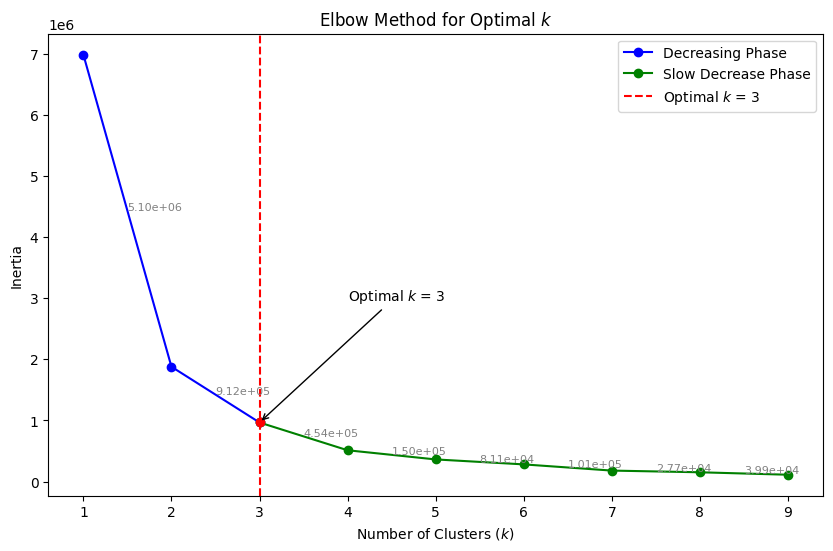

In [1301]:
# Feature Engineering - Create Lifetime Labels
clf_df = create_labels(df)

In [1302]:
# View the loaded data
clf_df.head()

,Lifespan,partType,microstructure,coolingRate,quenchTime,forgeTime,HeatTreatTime,Nickel%,Iron%,Cobalt%,Chromium%,smallDefects,largeDefects,sliverDefects,seedLocation,castType,Lifetime
0,1469.17,Nozzle,equiGrain,13,3.84,6.47,46.87,65.73,16.52,16.82,0.93,10,0,0,Bottom,Die,Unacceptable
1,1793.64,Block,singleGrain,19,2.62,3.48,44.70,54.22,35.38,6.14,4.26,19,0,0,Bottom,Investment,Good
2,700.60,Blade,equiGrain,28,0.76,1.34,9.54,51.83,35.95,8.81,3.41,35,3,0,Bottom,Investment,Unacceptable
3,1082.10,Nozzle,colGrain,9,2.01,2.19,20.29,57.03,23.33,16.86,2.78,0,1,0,Top,Continuous,Unacceptable
4,1838.83,Blade,colGrain,16,4.13,3.87,16.13,59.62,27.37,11.45,1.56,10,0,0,Top,Die,Good


In [1303]:
# Display the cluster ranges
# Group the data by 'Lifetime' and aggregate to find the min and max Lifespan for each group
cluster_ranges = clf_df.groupby('Lifetime')['Lifespan'].agg(['min', 'max']).sort_values(by='min').reset_index()
# Display the sorted DataFrame
display(cluster_ranges)

,Lifetime,min,max
0,Unacceptable,417.99,1499.31
1,Fair,1501.76,1661.54
2,Good,1666.64,1850.75
3,Excellent,1854.50,2134.53


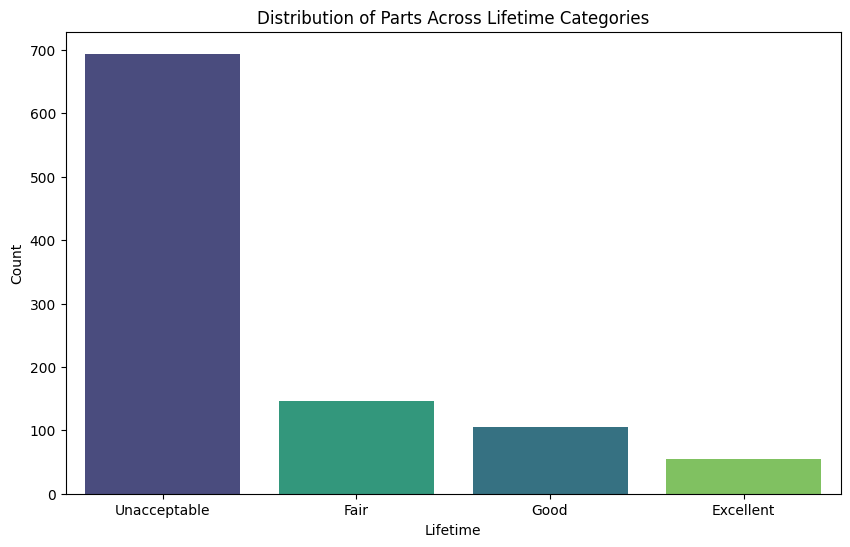

In [1304]:
def plot_lifetime_distribution(df):
    plt.figure(figsize=(10, 6))
    sns.countplot(
        x='Lifetime',
        data=df,
        hue='Lifetime',
        order=cluster_ranges['Lifetime'].unique(),
        palette='viridis',
        dodge=False,
        legend=False
    )
    plt.xlabel('Lifetime')
    plt.ylabel('Count')
    plt.title('Distribution of Parts Across Lifetime Categories')
    plt.show()

# Call the function to visualize the plot
plot_lifetime_distribution(clf_df)

In [1305]:
unique_lifespan_count = clf_df['Lifespan'].nunique()
print(f"Number of unique values in 'Lifespan' column: {unique_lifespan_count}")

Number of unique values in 'Lifespan' column: 998


In [1306]:
# Find the unique values that occur more than once in the 'Lifespan' column
duplicate_values = clf_df['Lifespan'].value_counts()
duplicate_values = duplicate_values[duplicate_values > 1]

# Output the unique values and their counts
print(duplicate_values)

Lifespan
1262.14    2
932.69     2
Name: count, dtype: int64


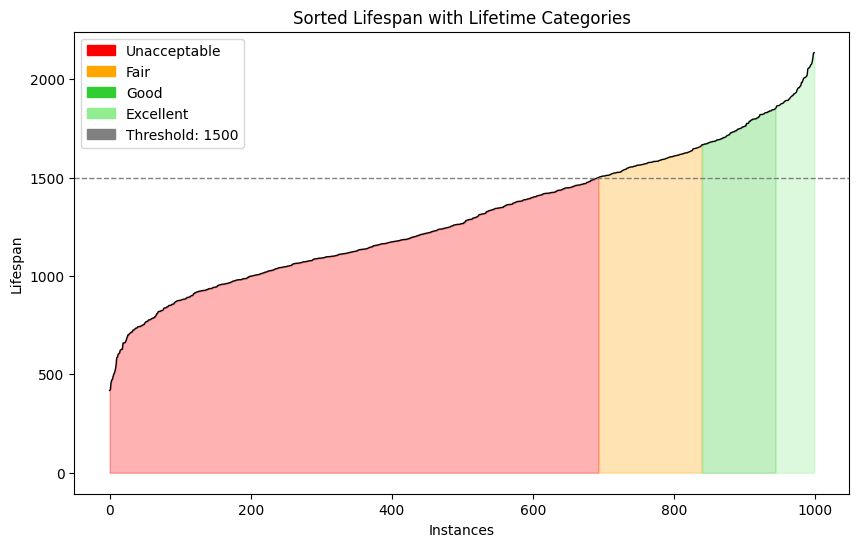

In [1307]:
def plot_lifespan_distribution(df):
    # Sort the DataFrame by 'Lifespan'
    df_sorted = df.sort_values('Lifespan').reset_index(drop=True)

    # Define colour mapping for 'Lifetime' categories
    colour_mapping = {
        'Unacceptable': 'red',
        'Fair': 'orange',
        'Good': 'limegreen',
        'Excellent': 'lightgreen'
    }

    # Extract values
    x = df_sorted.index
    y = df_sorted['Lifespan']
    categories = df_sorted['Lifetime']

    # Plot the thin line graph of 'Lifespan'
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, color='black', linewidth=1)

    # Group by consecutive 'Lifetime' categories
    for key, group in groupby(zip(x, y, categories), lambda t: t[2]):
        group = list(group)
        x_vals = [item[0] for item in group]
        y_vals = [item[1] for item in group]
        plt.fill_between(x_vals, y_vals, color=colour_mapping[key], alpha=0.3)

    # Add a grey dotted horizontal line at y = 1500
    plt.axhline(y=1500, color='grey', linestyle='--', linewidth=1, label='Threshold: 1500')

    # Create legend handles
    handles = [mpatches.Patch(color=colour, label=category) for category, colour in colour_mapping.items()]
    handles.append(mpatches.Patch(color='grey', label='Threshold: 1500'))  # Add to legend
    plt.legend(handles=handles)

    plt.xlabel('Instances')
    plt.ylabel('Lifespan')
    plt.title('Sorted Lifespan with Lifetime Categories')
    plt.show()

plot_lifespan_distribution(clf_df)

In [ ]:
# Bin 'Lifespan' into quartiles
clf_df['Lifespan_bin'] = pd.qcut(clf_df['Lifespan'], q=4, duplicates='drop')

# Create a combined stratification label
clf_df['Stratify_Label'] = clf_df['Lifetime'] + '_' + clf_df['Lifespan_bin'].astype(str)

# First, split into training and temp (validation + test)
clf_train_df, temp_df = train_test_split(
    clf_df,
    test_size=0.3,
    stratify=clf_df['Stratify_Label'],
    random_state=random_state
)

# Then, split temp_df equally into validation and test sets
clf_val_df, clf_test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['Stratify_Label'],
    random_state=random_state
)

# Remove the temporary DataFrame
del temp_df

# Optionally, drop the temporary columns
clf_train_df = clf_train_df.drop(columns=['Lifespan_bin', 'Stratify_Label'])
clf_val_df = clf_val_df.drop(columns=['Lifespan_bin', 'Stratify_Label'])
clf_test_df = clf_test_df.drop(columns=['Lifespan_bin', 'Stratify_Label'])

train_shape, val_shape, test_shape = clf_train_df.shape, clf_val_df.shape, clf_test_df.shape
print(f"Training set shape   : {train_shape}")
print(f"Validation set shape : {val_shape}")
print(f"Test set shape       : {test_shape}")

Training set shape   : (700, 17)
Validation set shape : (150, 17)
Test set shape       : (150, 17)


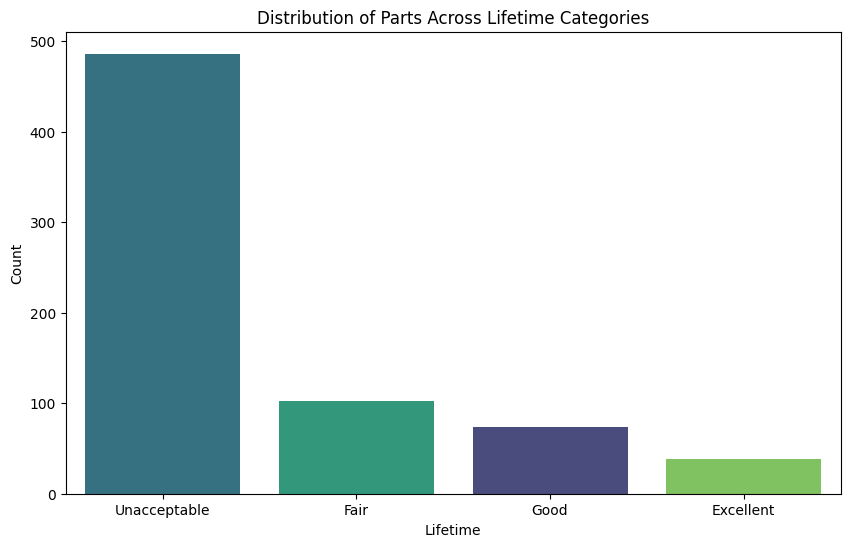

In [1309]:
plot_lifetime_distribution(clf_train_df)

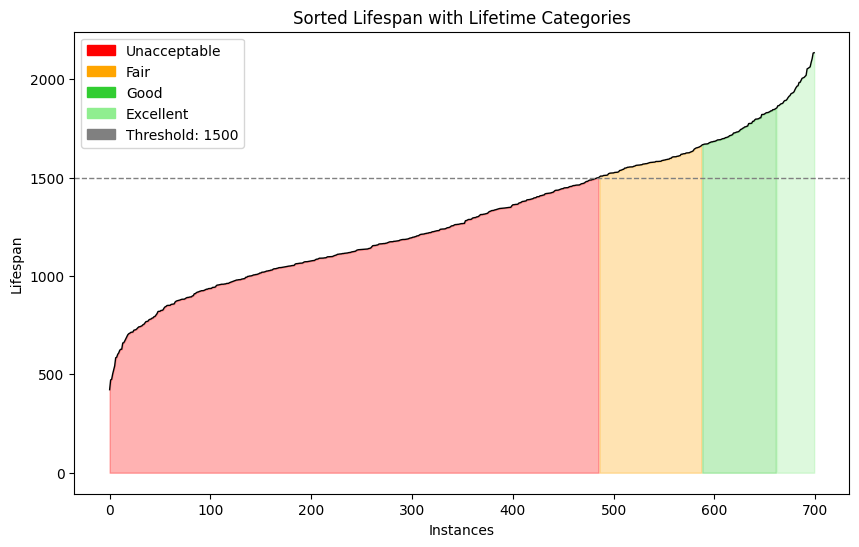

In [1310]:
plot_lifespan_distribution(clf_train_df)

In [1311]:
clf_train_df = clf_train_df.drop(columns=['Lifespan'])
clf_val_df = clf_val_df.drop(columns=['Lifespan'])
clf_test_df = clf_test_df.drop(columns=['Lifespan'])

# Removing the 'Lifespan' column from the split sets.
train_shape, val_shape, test_shape = clf_train_df.shape, clf_val_df.shape, clf_test_df.shape
print("After removing the 'Lifespan' column:")
print(f"Training set shape   : {train_shape}")
print(f"Validation set shape : {val_shape}")
print(f"Test set shape       : {test_shape}")

After removing the 'Lifespan' column:
Training set shape   : (700, 16)
Validation set shape : (150, 16)
Test set shape       : (150, 16)


In [1312]:
# Define the feature columns
numeric_features = clf_train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = [col for col in clf_train_df.columns if clf_train_df[col].dtype in ['object'] and col != 'Lifetime']

In [1313]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=int, drop=None)
le = LabelEncoder()

In [1314]:
# Preprocessing for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', ohe)
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Define the model
model_name = "Logistic Regression"
logistic_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=random_state))
])

# Separate features and target
X_train = clf_train_df.drop(columns=['Lifetime'])
y_train = clf_train_df['Lifetime']

# Fit the model
logistic_model.fit(X_train, y_train)

# Print the model's score on the training data
train_score = logistic_model.score(X_train, y_train)
print(f"{model_name} training accuracy: {train_score:.2f}")

Logistic Regression training accuracy: 0.69


In [1315]:
# Separate features and target from the test DataFrame
X_test = clf_test_df.drop(columns=['Lifetime'])
y_test = clf_test_df['Lifetime']

# Predict the target values using the trained model
y_pred = logistic_model.predict(X_test)

# Calculate the accuracy score
test_accuracy = accuracy_score(y_test, y_pred)
print(f"{model_name} test accuracy: {test_accuracy:.2f}")

Logistic Regression test accuracy: 0.68


In [1316]:
# Preprocessing for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', ohe)
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Separate features and target
X_train = clf_train_df.drop(columns=['Lifetime'])
y_train = clf_train_df['Lifetime']

# Fit and transform the training data
X_train_processed = preprocessor.fit_transform(X_train)

# Encode the target labels using LabelEncoder
y_train_encoded = le.fit_transform(y_train)

# Compute class weights to handle class imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)
class_weights_dict = dict(enumerate(class_weights))

# Build the Neural Network model (Warning Fixed)
model = models.Sequential([
    layers.Input(shape=(X_train_processed.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len(np.unique(y_train_encoded)), activation='softmax')
])

# Compile the model with appropriate loss function and optimizer
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Set up early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train_processed,
    y_train_encoded,
    epochs=100,
    batch_size=32,
    class_weight=class_weights_dict,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model on the training data
train_loss, train_accuracy = model.evaluate(X_train_processed, y_train_encoded, verbose=0)
print(f"Neural Network training accuracy: {train_accuracy:.2f}")

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2741 - loss: 2.2533 - val_accuracy: 0.4286 - val_loss: 1.3178
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3161 - loss: 1.7079 - val_accuracy: 0.4643 - val_loss: 1.2768
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3380 - loss: 1.5967 - val_accuracy: 0.4357 - val_loss: 1.2563
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3085 - loss: 1.6153 - val_accuracy: 0.4571 - val_loss: 1.2341
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3079 - loss: 1.4835 - val_accuracy: 0.4643 - val_loss: 1.2203
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3777 - loss: 1.4028 - val_accuracy: 0.4786 - val_loss: 1.2084
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3417 - loss: 1.5142 - val_accuracy: 0.4643 - val_loss: 1.1954
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3399 - loss: 1.3561 - val_accuracy: 0.4643 - v

In [1317]:
# Preprocess the test data
X_test = clf_test_df.drop(columns=['Lifetime'])
y_test = clf_test_df['Lifetime']

X_test_processed = preprocessor.transform(X_test)
y_test_encoded = le.transform(y_test)

# Predict the target values using the trained model
y_pred_probs = model.predict(X_test_processed)
y_pred = np.argmax(y_pred_probs, axis=1)

# Import metrics for evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Calculate the accuracy score (Test Accuracy Added)
test_accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Neural Network test accuracy: {test_accuracy:.2f}")

# Print the classification report
print("Classification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Neural Network test accuracy: 0.63
Classification Report:
              precision    recall  f1-score   support

   Excellent       0.14      0.12      0.13         8
        Fair       0.26      0.45      0.33        22
        Good       0.15      0.19      0.17        16
Unacceptable       0.95      0.77      0.85       104

    accuracy                           0.63       150
   macro avg       0.38      0.38      0.37       150
weighted avg       0.72      0.63      0.66       150

Confusion Matrix:
[[ 1  5  2  0]
 [ 0 10  9  3]
 [ 4  8  3  1]
 [ 2 16  6 80]]


In [1318]:
# Preprocessing for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical features
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', ohe)
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Separate features and target
X_train = clf_train_df.drop(columns=['Lifetime'])
y_train = clf_train_df['Lifetime']

# Fit and transform the training data
X_train_processed = preprocessor.fit_transform(X_train)

# Encode the target labels using LabelEncoder
y_train_encoded = le.fit_transform(y_train)

# Compute class weights to handle imbalance
class_weights = dict(enumerate(
    len(y_train) / (len(np.unique(y_train_encoded)) * np.bincount(y_train_encoded))
))

# Build the Neural Network model with improved architecture
model = models.Sequential([
    layers.Input(shape=(X_train_processed.shape[1],)),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # L2 Regularization
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # L2 Regularization
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),   # L2 Regularization
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(len(np.unique(y_train_encoded)), activation='softmax')
])         # L2 Regularization added to prevent overfitting to the majority class.

# Compile the model with optimized parameters
optimizer = Adam(learning_rate=0.0005)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Set up callbacks for better training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    mode='min'
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=10,
    min_lr=1e-6,
    mode='min'
)

# Train the model with improved parameters
history = model.fit(
    X_train_processed,
    y_train_encoded,
    epochs=200,
    batch_size=32,
    class_weight=class_weights,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate the model on the training data
train_loss, train_accuracy = model.evaluate(X_train_processed, y_train_encoded, verbose=0)
print(f"Neural Network training accuracy: {train_accuracy:.2f}")

Epoch 1/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2676 - loss: 4.7631 - val_accuracy: 0.3571 - val_loss: 4.2992 - learning_rate: 5.0000e-04
Epoch 2/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2548 - loss: 4.5737 - val_accuracy: 0.2714 - val_loss: 4.3229 - learning_rate: 5.0000e-04
Epoch 3/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3030 - loss: 4.3953 - val_accuracy: 0.2286 - val_loss: 4.3435 - learning_rate: 5.0000e-04
Epoch 4/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2907 - loss: 4.3601 - val_accuracy: 0.2071 - val_loss: 4.3625 - learning_rate: 5.0000e-04
Epoch 5/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3241 - loss: 4.2505 - val_accuracy: 0.1714 - val_loss: 4.3846 - learning_rate: 5.0000e-04
Epoch 6/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3333 - loss: 4.2000 - val_accuracy: 0.1714 - val_loss: 4.3925 - learning_rate: 5.0000e-04
Epoch 7/200
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3143 

In [1319]:
# Preprocess the test data
X_test = clf_test_df.drop(columns=['Lifetime'])
y_test = clf_test_df['Lifetime']

X_test_processed = preprocessor.transform(X_test)
y_test_encoded = le.transform(y_test)

# Predict the target values using the trained model
y_pred_probs = model.predict(X_test_processed, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Import metrics for evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

# Calculate various metrics
test_accuracy = accuracy_score(y_test_encoded, y_pred)
f1_macro = f1_score(y_test_encoded, y_pred, average='macro')
f1_weighted = f1_score(y_test_encoded, y_pred, average='weighted')

print(f"Neural Network test accuracy: {test_accuracy:.2f}")
print(f"F1 Score (Macro): {f1_macro:.2f}")
print(f"F1 Score (Weighted): {f1_weighted:.2f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred))

# Print prediction probabilities for a few examples
print("\nSample Predictions with Probabilities:")
for i in range(min(5, len(y_test))):
    probs = y_pred_probs[i]
    pred_class = le.inverse_transform([y_pred[i]])[0]
    true_class = le.inverse_transform([y_test_encoded[i]])[0]
    print(f"\nSample {i+1}:")
    print(f"True Class: {true_class}")
    print(f"Predicted Class: {pred_class}")
    print("Class Probabilities:")
    for j, prob in enumerate(probs):
        class_name = le.inverse_transform([j])[0]
        print(f"{class_name}: {prob:.3f}")

Neural Network test accuracy: 0.61
F1 Score (Macro): 0.44
F1 Score (Weighted): 0.66

Classification Report:
              precision    recall  f1-score   support

   Excellent       0.20      0.50      0.29         8
        Fair       0.30      0.50      0.37        22
        Good       0.28      0.31      0.29        16
Unacceptable       0.96      0.69      0.80       104

    accuracy                           0.61       150
   macro avg       0.43      0.50      0.44       150
weighted avg       0.75      0.61      0.66       150


Confusion Matrix:
[[ 4  3  1  0]
 [ 3 11  6  2]
 [ 6  4  5  1]
 [ 7 19  6 72]]

Sample Predictions with Probabilities:

Sample 1:
True Class: Unacceptable
Predicted Class: Unacceptable
Class Probabilities:
Excellent: 0.051
Fair: 0.298
Good: 0.291
Unacceptable: 0.361

Sample 2:
True Class: Unacceptable
Predicted Class: Unacceptable
Class Probabilities:
Excellent: 0.005
Fair: 0.002
Good: 0.007
Unacceptable: 0.986

Sample 3:
True Class: Good
Predicted Cla

In [1320]:
# Separate features and target
X_train = clf_train_df.drop(columns=['Lifetime'])
y_train = clf_train_df['Lifetime']

# Print original class distribution
print("Original class distribution:")
print(y_train.value_counts())

# Define numeric and categorical columns
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', ohe, categorical_features)
    ])

# Fit and transform the data
X_train_transformed = preprocessor.fit_transform(X_train)

# Initialize and fit SMOTE
smote = SMOTE(random_state=random_state)
X_smote, y_smote = smote.fit_resample(X_train_transformed, y_train)

# Get feature names after one-hot encoding
cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = numeric_features + cat_feature_names.tolist()

# Create new balanced dataframe with transformed features
smoted_df = pd.DataFrame(X_smote, columns=feature_names)
smoted_df['Lifetime'] = y_smote

# Print new class distribution
print("\nClass distribution after SMOTE:")
print(smoted_df['Lifetime'].value_counts())

# Print shape comparison
print("\nShape comparison:")
print(f"Original training data shape       : {clf_train_df.shape}")
print(f"SMOTE-balanced training data shape : {smoted_df.shape}")

Original class distribution:
Lifetime
Unacceptable    486
Fair            102
Good             74
Excellent        38
Name: count, dtype: int64

Class distribution after SMOTE:
Lifetime
Good            486
Unacceptable    486
Fair            486
Excellent       486
Name: count, dtype: int64

Shape comparison:
Original training data shape       : (700, 16)
SMOTE-balanced training data shape : (1944, 24)


In [1321]:
for col in smoted_df.columns:
    print(f"- {col}")

- coolingRate
- quenchTime
- forgeTime
- HeatTreatTime
- Nickel%
- Iron%
- Cobalt%
- Chromium%
- smallDefects
- largeDefects
- sliverDefects
- partType_Blade
- partType_Block
- partType_Nozzle
- partType_Valve
- microstructure_colGrain
- microstructure_equiGrain
- microstructure_singleGrain
- seedLocation_Bottom
- seedLocation_Top
- castType_Continuous
- castType_Die
- castType_Investment
- Lifetime


In [1322]:
smoted_df.head()

,coolingRate,quenchTime,forgeTime,HeatTreatTime,Nickel%,Iron%,Cobalt%,Chromium%,smallDefects,largeDefects,...,partType_Valve,microstructure_colGrain,microstructure_equiGrain,microstructure_singleGrain,seedLocation_Bottom,seedLocation_Top,castType_Continuous,castType_Die,castType_Investment,Lifetime
0,0.163225,0.786757,-0.307109,1.085357,-0.813631,-0.044375,0.794197,1.239172,-0.460254,-0.462992,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,Good
1,0.694656,-0.103604,-0.132732,-1.506822,-1.042338,-0.166677,1.497499,0.627807,0.776671,3.003257,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,Unacceptable
2,-0.501063,1.281402,-0.307109,0.137215,0.314543,0.448868,-1.552443,1.186338,-0.625177,-0.462992,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,Good
3,-0.633921,0.687828,-0.450486,-1.587753,-0.729999,0.934048,-0.476804,-0.451515,-0.872562,-0.462992,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,Fair
4,1.491802,0.208403,-1.202245,-0.589398,1.423942,-1.537544,0.987260,-0.904377,1.518826,-0.462992,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,Unacceptable


In [1323]:
# The features are already preprocessed in smoted_df, we just need to separate X and y
X_train_smote = smoted_df.drop(columns=['Lifetime'])
y_train_smote = smoted_df['Lifetime']

# Encode target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_smote)

# Build the Neural Network model with improved architecture
model = models.Sequential([
    layers.Input(shape=(X_train_smote.shape[1],)),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(len(np.unique(y_train_encoded)), activation='softmax')
])

# Compile the model with optimized parameters
optimizer = Adam(learning_rate=0.0005)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Set up callbacks for better training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    mode='min'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=10,
    min_lr=1e-6,
    mode='min'
)

# Train the model
history = model.fit(
    X_train_smote,
    y_train_encoded,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate on training data
train_loss, train_accuracy = model.evaluate(X_train_smote, y_train_encoded, verbose=0)
print(f"\nNeural Network training accuracy: {train_accuracy:.2f}")

Epoch 1/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2966 - loss: 4.7735 - val_accuracy: 0.0103 - val_loss: 4.5011 - learning_rate: 5.0000e-04
Epoch 2/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5104 - loss: 4.0892 - val_accuracy: 0.0000e+00 - val_loss: 4.6066 - learning_rate: 5.0000e-04
Epoch 3/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5849 - loss: 3.7919 - val_accuracy: 0.0000e+00 - val_loss: 4.6881 - learning_rate: 5.0000e-04
Epoch 4/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6347 - loss: 3.5968 - val_accuracy: 0.0000e+00 - val_loss: 4.6600 - learning_rate: 5.0000e-04
Epoch 5/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6875 - loss: 3.3793 - val_accuracy: 0.0000e+00 - val_loss: 4.6166 - learning_rate: 5.0000e-04
Epoch 6/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6838 - loss: 3.2522 - val_accuracy: 0.0000e+00 - val_loss: 4.6131 - learning_rate: 5.0000e-04
Epoch 7/200
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

In [1324]:
# Preprocess test data using the same preprocessing steps
X_test = clf_test_df.drop(columns=['Lifetime'])
y_test = clf_test_df['Lifetime']

# Transform test data using the same preprocessor
X_test_transformed = preprocessor.transform(X_test)

# Encode test labels
y_test_encoded = label_encoder.transform(y_test)

# Get predictions
y_pred_probs = model.predict(X_test_transformed, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate various metrics
test_accuracy = accuracy_score(y_test_encoded, y_pred)
f1_macro = f1_score(y_test_encoded, y_pred, average='macro')
f1_weighted = f1_score(y_test_encoded, y_pred, average='weighted')

print(f"Neural Network test accuracy: {test_accuracy:.2f}")
print(f"F1 Score (Macro): {f1_macro:.2f}")
print(f"F1 Score (Weighted): {f1_weighted:.2f}")

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_encoded, y_pred))

# Print prediction probabilities for a few examples
print("\nSample Predictions with Probabilities:")
for i in range(min(5, len(y_test))):
    probs = y_pred_probs[i]
    pred_class = label_encoder.inverse_transform([y_pred[i]])[0]
    true_class = label_encoder.inverse_transform([y_test_encoded[i]])[0]
    print(f"\nSample {i+1}:")
    print(f"True Class: {true_class}")
    print(f"Predicted Class: {pred_class}")
    print("Class Probabilities:")
    for j, prob in enumerate(probs):
        class_name = label_encoder.inverse_transform([j])[0]
        print(f"{class_name}: {prob:.3f}")

Neural Network test accuracy: 0.75
F1 Score (Macro): 0.48
F1 Score (Weighted): 0.72

Classification Report:
              precision    recall  f1-score   support

   Excellent       0.67      0.25      0.36         8
        Fair       0.32      0.32      0.32        22
        Good       0.44      0.25      0.32        16
Unacceptable       0.85      0.95      0.90       104

    accuracy                           0.75       150
   macro avg       0.57      0.44      0.48       150
weighted avg       0.72      0.75      0.72       150


Confusion Matrix:
[[ 2  4  2  0]
 [ 0  7  3 12]
 [ 1  6  4  5]
 [ 0  5  0 99]]

Sample Predictions with Probabilities:

Sample 1:
True Class: Unacceptable
Predicted Class: Unacceptable
Class Probabilities:
Excellent: 0.000
Fair: 0.047
Good: 0.000
Unacceptable: 0.952

Sample 2:
True Class: Unacceptable
Predicted Class: Unacceptable
Class Probabilities:
Excellent: 0.000
Fair: 0.000
Good: 0.000
Unacceptable: 1.000

Sample 3:
True Class: Good
Predicted Cla